# Reinforcement Learning with Q-Learning

## What is Reinforcement Learning?

**Reinforcement Learning (RL)** is a type of machine learning where an agent learns to make decisions by interacting with an environment:

1. **Agent**: The learner (our Q-learning algorithm)
2. **Environment**: The world (FrozenLake grid)
3. **State**: Current situation (position on grid)
4. **Action**: What the agent can do (move LEFT/DOWN/RIGHT/UP)
5. **Reward**: Feedback from environment (+1 for goal, 0 otherwise)
6. **Policy**: Strategy for choosing actions

## Q-Learning Overview

**Q-Learning** is a *model-free* reinforcement learning algorithm:
- **Model-free**: We don't need to know the environment dynamics in advance
- **Off-policy**: We can learn the optimal policy while following a different policy (exploration)
- **Value-based**: We learn the value of state-action pairs


## The Process

### Step 1: Initialize
- Create a Q-table (states × actions) filled with zeros
- The agent knows nothing at the start

### Step 2: Training Loop
For many episodes:
1. Start at initial state
2. Choose action using **epsilon-greedy policy** (explore vs exploit)
3. Take action, observe reward and new state
4. **Update Q-value** using: Q(s,a) ← Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
5. Repeat until episode ends
6. Gradually reduce exploration (epsilon decay)

### Step 3: Evaluation
- Test the learned policy using **greedy policy** (no exploration)
- Measure performance (average reward)

### Step 4: Use the trained agent
- Deploy the agent using the learned Q-table
- Always choose action with highest Q-value for each state

## Key Insight

The agent learns by **trial and error**, gradually building up knowledge of which actions lead to the goal and which lead to failure. The Q-table becomes a "cheat sheet" for navigating the environment optimally!

We are using the frozen lake environment as a basic example of a 

https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake.

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated. Randomly generated worlds will always have a path to the goal.

The player makes moves until they reach the goal or fall in a hole.

The lake can be slippery (unless disabled) so the player may move perpendicular to the intended direction sometimes.

In [1]:
import numpy as np
import random

/home/avidaldo/TRABAJO/wip-clase/.venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


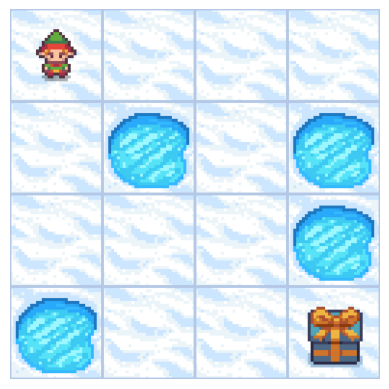

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make(
    'FrozenLake-v1',
    desc=None,
    map_name="4x4",
    is_slippery=False,  # Deterministic environment
    render_mode="rgb_array"  # Notebook rendering
)

env.reset() # Reset the environment

def show_env(env):
    '''Render and display the environment in the notebook.'''
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_env(env)

The environment was created with the default map:

```python
desc=["SFFF","FHFH","FFFH","HFFG"]
```

<table border="1">
        <tr><td>S</td><td>F</td><td>F</td><td>F</td></tr>
        <tr><td>F</td><td>H</td><td>F</td><td>H</td></tr>
        <tr><td>F</td><td>F</td><td>F</td><td>H</td></tr>
        <tr><td>H</td><td>F</td><td>F</td><td>G</td></tr>
</table>
<p><b>S</b>=Start, <b>F</b>=Frozen, <b>H</b>=Hole, <b>G</b>=Goal</p>

In [3]:
print("Observation Space", env.observation_space)

Observation Space Discrete(16)


We see with `Observation Space Shape Discrete(16)` that the observation is a value representing the **agent's current position as current_row * nrows + current_col (where both the row and col start at 0)**.

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**


<table border="1">
  <tr><td>0</td><td>1</td><td>2</td><td>3</td></tr>
  <tr><td>4</td><td>5</td><td>6</td><td>7</td></tr>
  <tr><td>8</td><td>9</td><td>10</td><td>11</td></tr>
  <tr><td>12</td><td>13</td><td>14</td><td>15</td></tr>
</table>


In [4]:
print("Action Space Shape", env.action_space)

Action Space Shape Discrete(4)


The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

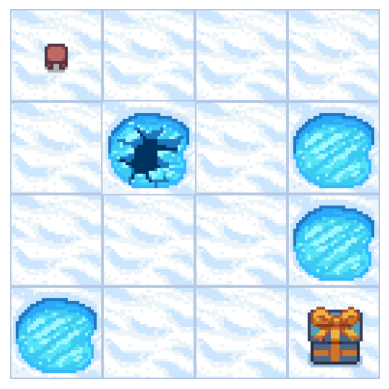

Episode 10, Step 2: State 4 --Action 2--> Next State 5, Reward: 0
Episode 10 finished in 2 steps.



In [19]:
from IPython.display import clear_output
import time

for episode in range(10):
    state, info = env.reset()
    done = False
    step = 0
    print(f"Episode {episode + 1} starting...")

    # Show initial state
    clear_output(wait=True)
    show_env(env)
    print(f"Episode {episode + 1}, Step {step}: State {state}")
    time.sleep(0.1)

    while not done:
        action = env.action_space.sample()  # Random action
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        step += 1

        # Clear and show updated environment
        clear_output(wait=True)
        show_env(env)
        print(f"Episode {episode + 1}, Step {step}: State {state} --Action {action}--> Next State {next_state}, Reward: {reward}")

        state = next_state
        time.sleep(0.05)  # Pause between frames

    print(f"Episode {episode + 1} finished in {step} steps.\n")
    time.sleep(1)  # Pause between episodes

In [7]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [8]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable


Qtable_frozenlake = initialize_q_table(state_space, action_space)
Qtable_frozenlake

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

#### Understanding the Q-Table

The Q-table is a **lookup table** that stores the expected reward for each state-action pair.

**Structure**:
- **Rows**: States (16 positions on the 4×4 grid)
- **Columns**: Actions (4 possible moves: LEFT, DOWN, RIGHT, UP)
- **Values**: Q(state, action) = expected future reward

**Initialization**:
- All values start at 0 (the agent knows nothing)
- As training progresses, values will update to reflect learned knowledge

**Example**: 
- Q[5][2] = expected reward if we're in state 5 and take action 2 (RIGHT)
(However, Q[5][*] will always be 0 since position 5 is a hole and there are no valid actions from a hole)
- The agent will learn which actions lead to the goal (+1 reward) and which lead to holes (0 reward)

### Step 3: Define the policies 🤖

#### The Exploration-Exploitation trade-off

In reinforcement learning, the agent faces a fundamental challenge:
- **Exploration**: Try new actions to discover potentially better strategies
- **Exploitation**: Use known good actions to maximize reward

#### Greedy Policy (Pure Exploitation)

The greedy policy always selects the action with the highest Q-value for a given state. 

In [9]:
def greedy_policy(Qtable, state):
    """
    Greedy policy: always select the action with highest Q-value.
    Used during EVALUATION (no exploration, pure exploitation).
    
    Args:
        Qtable: The Q-table with learned values
        state: The current state
        
    Returns:
        action: The action with maximum Q-value for this state
    """
    # Take the action with the highest value given a state
    action = np.argmax(Qtable[state])
    return action

#### Epsilon-Greedy Policy (Exploration + Exploitation)

Epsilon-Greedy is the **training policy** that handles the exploration/exploitation trade-off.

The idea with Epsilon Greedy:
- With *probability 1 - ɛ*: **we do exploitation** (select the action with highest Q-value, like greedy_policy)
- With *probability ɛ*: **we do exploration** (try a random action)

As training progresses, we **reduce epsilon** gradually:
- Early training: High ɛ (more exploration) → discover the environment
- Late training: Low ɛ (more exploitation) → refine the learned strategy

**Note**: epsilon_greedy_policy includes the greedy behavior when random_num > epsilon, so it's a generalization of greedy_policy!

In [10]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    """
    Epsilon-greedy policy: balance exploration and exploitation.
    Used during TRAINING.
    
    Args:
        Qtable: The Q-table with current values
        state: The current state
        epsilon: Probability of exploration (0 to 1)
        
    Returns:
        action: Either best action (exploitation) or random action (exploration)
    """
    # Generate a random number between 0 and 1
    random_num = random.uniform(0, 1)
    
    # If random_num > epsilon --> EXPLOITATION
    if random_num > epsilon:
        # Use greedy policy (take the action with highest Q-value)
        action = greedy_policy(Qtable, state)
    # Else --> EXPLORATION
    else:
        # Take a random action to discover new possibilities
        action = env.action_space.sample()
    
    return action

Greedy policy is used **during evaluation** when we want to test what the agent has learned without any randomness. For training, we use epsilon-greedy to allow exploration.

### Hyperparameters Explained

Hyperparameters control how the agent learns. Let's understand each one:

#### Training Parameters
- **n_training_episodes = 10,000**: How many games the agent plays during learning
  - More episodes = more learning, but takes longer
  
- **learning_rate (α) = 0.7**: How much we update Q-values each step
  - High (0.7-1.0): Learn fast, but may overshoot optimal values
  - Low (0.1-0.3): Learn slowly, but more stable
  - We use 0.7 for relatively fast learning

#### Environment Parameters  
- **gamma (γ) = 0.95**: Discount factor for future rewards
  - Close to 1.0 (0.95): Value future rewards highly (plan ahead)
  - Close to 0.0: Only care about immediate rewards
  - FrozenLake needs planning, so we use 0.95

  
- **max_steps = 99**: Maximum steps per episode
  - Prevents infinite loops if agent gets stuck

#### Exploration Parameters (Epsilon Decay)
- **max_epsilon = 1.0**: Start with 100% exploration
  - At the beginning, agent knows nothing, so explore everything!
  
- **min_epsilon = 0.05**: End with 5% exploration  
  - Even after learning, keep 5% exploration to avoid getting stuck
  
- **decay_rate = 0.0005**: How fast epsilon decreases
  - Controls the speed of transition from exploration to exploitation
  - With 10,000 episodes and decay 0.0005, epsilon gradually decreases

#### Evaluation Parameters
- **n_eval_episodes = 100**: Test the agent 100 times
  - More episodes give better statistical confidence

In [11]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

### Step 4: The Training Algorithm - Q-Learning 📚

**Q-Learning** is a model-free reinforcement learning algorithm that learns the value of taking an action in a particular state.

#### The Q-Learning Update Rule

The heart of Q-Learning is this formula:

```
Q(s,a) ← Q(s,a) + α [R(s,a) + γ · max Q(s',a') - Q(s,a)]
```

Let's break it down:
- **Q(s,a)**: Current Q-value for state s and action a
- **α (alpha)**: Learning rate (how much we update, 0 to 1)
If α = 0, no learning happens; if α = 1, we fully adopt new information, ignoring old information.
- **R(s,a)**: Immediate reward received after taking action a in state s
- **γ (gamma)**: Discount factor (how much we value future rewards, 0 to 1)
- **max Q(s',a')**: Maximum Q-value for the next state s' (best possible future value)
- **[R(s,a) + γ · max Q(s',a') - Q(s,a)]**: Temporal Difference (TD) error

#### What does this mean?

1. **R(s,a)**: Immediate reward we just got
2. **γ · max Q(s',a')**: Best possible future reward (discounted)
3. **R(s,a) + γ · max Q(s',a')**: Total expected reward (immediate + future)
4. **[...] - Q(s,a)**: Difference between expected and current estimate (the "error")
5. **α × [error]**: Update step (we don't change Q-value fully, just a bit)

#### Training Loop Structure

1. **Outer loop**: Iterate over training episodes
   - Reduce epsilon (less exploration over time)
   - Reset environment
   
2. **Inner loop**: Steps within each episode
   - Choose action using epsilon-greedy policy
   - Take action and observe reward and next state
   - Update Q-table using Q-learning formula
   - If done (goal or hole), finish episode
   - Move to next state

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    """
    Train the agent using Q-learning algorithm.
    
    Args:
        n_training_episodes: Total number of training episodes
        min_epsilon: Minimum exploration probability
        max_epsilon: Maximum exploration probability
        decay_rate: Rate at which epsilon decays
        env: The Gymnasium environment
        max_steps: Maximum steps per episode
        Qtable: The Q-table to update
        
    Returns:
        Qtable: Updated Q-table after training
    """
    for episode in range(n_training_episodes):
        # Reduce epsilon (because we need less and less exploration)
        # Exponential decay: starts at max_epsilon, decays toward min_epsilon
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
        # Reset the environment to start a new episode
        state, info = env.reset()  # Gymnasium returns (state, info)
        step = 0
        done = False
        
        # Repeat until episode ends (goal reached, hole fallen, or max steps)
        for step in range(max_steps):
            # Choose action using epsilon-greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            
            # Take action and observe results
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update Q-table using Q-learning formula:
            # Q(s,a) ← Q(s,a) + α [R(s,a) + γ · max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )
            
            # If episode is done, finish
            if done:
                break
            
            # Move to the next state
            state = new_state
            
    return Qtable

In [13]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

### Training Complete! 🎉

After training, the Q-table now contains learned values instead of all zeros.

**What to expect:**
- Some Q-values will be high (positive) → these state-action pairs lead toward the goal
- Some Q-values will remain low or zero → these lead to holes or dead ends
- The pattern of Q-values represents the agent's "knowledge" of the environment

**Note**: The Q-table values represent the expected cumulative discounted reward, not just immediate reward. A value of 0.5 might mean "if I take this action, I have about 50% chance of eventually reaching the goal."

### Step 5: Evaluation 📊

After training, we need to **evaluate** how well our agent has learned.

#### Why Separate Training and Evaluation?

**During Training** (using `epsilon_greedy_policy`):
- Agent explores randomly with probability ε
- This helps discover optimal strategies
- Performance is not representative of what the agent "knows"

**During Evaluation** (using `greedy_policy`):
- Agent uses only the best learned actions (no randomness)
- This shows the true quality of the learned policy
- We want to see: "What would the agent do if it only uses what it learned?"

#### Key Difference

This is **exactly why we need both functions**:
- `epsilon_greedy_policy`: For learning (training)
- `greedy_policy`: For testing (evaluation)

The `evaluate_agent` function:
1. Runs multiple episodes using **greedy policy only**
2. Collects rewards from each episode
3. Calculates mean and standard deviation
4. Returns performance metrics

In [14]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """
    Evaluate the trained agent without exploration.
    
    This function tests how well the agent has learned by running episodes
    using only GREEDY policy (no exploration, pure exploitation).
    
    Args:
        env: The Gymnasium environment
        max_steps: Maximum steps per episode
        n_eval_episodes: Number of evaluation episodes
        Q: The trained Q-table
        seed: Random seeds for reproducibility (optional)
        
    Returns:
        mean_reward: Average reward over all evaluation episodes
        std_reward: Standard deviation of rewards
    """
    episode_rewards = []
    
    for episode in range(n_eval_episodes):
        # Reset with seed if provided, otherwise random
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
            
        step = 0
        done = False
        total_rewards_ep = 0
        
        for step in range(max_steps):
            # Use GREEDY policy for evaluation (no exploration!)
            # This is why we need the separate greedy_policy function
            action = greedy_policy(Q, state)
            
            # Take action - NEW Gymnasium API
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            total_rewards_ep += reward
            
            if done:
                break
                
            state = new_state
            
        episode_rewards.append(total_rewards_ep)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    
    return mean_reward, std_reward

In [15]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


### Interpretation of Results

Perfect performance! 🎯

```
Mean_reward=1.00 +/- 0.00
```

**What this means:**
- **Mean reward = 1.00**: The agent reached the goal in 100% of evaluation episodes
- **Standard deviation = 0.00**: No variance - perfect consistency
- The agent has fully learned the optimal policy for this deterministic FrozenLake environment

This is expected because:
1. The environment is deterministic (`is_slippery=False`)
2. We trained for 10,000 episodes - enough to learn the simple 4×4 grid
3. The learned Q-table now encodes the optimal path from start to goal

Visualizing the result
Till now, we have been playing with numbers, and to give the demo, we need to create an animated Gif of the agent from the start till it reaches the goal. 

We will first create the state by resetting the environment with a random integer 0-500. 
Render the environment using rdb_array to create an image array. 
Then append the img to the images array. 
In the loop, we will take the step using the Q-Table and render the image for every step. 
In the end, we will use this array and imageio to create a Gif of one frame per second.

In [16]:
def record_video(env, Qtable, out_directory, fps=1):
    """
    Record a video of the agent playing using the learned Q-table.
    Uses greedy policy (best actions only, no exploration).
    """
    images = [] 
    done = False
    
    # Reset with a random seed
    state, info = env.reset(seed=random.randint(0, 500))
    img = env.render()
    images.append(img)
    
    while not done:
        # Take the action with maximum Q-value (greedy policy)
        action = greedy_policy(Qtable, state)
        
        # Take action - NEW Gymnasium API
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        img = env.render()
        images.append(img)
        
    # Save as GIF
    import imageio
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

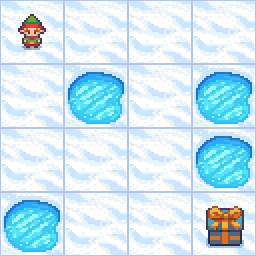

In [17]:
video_path="replay.gif"  # Save in current directory
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image(video_path)

- https://www.youtube.com/watch?v=L-kQSpCJH4Q
- https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
- https://colab.research.google.com/drive/1Ur_pYvL_IngmAttMBSZlBRwMNnpzQuY_#scrollTo=jNxUbPMP0akP